In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from giems_lstm.config import Config
import os

os.chdir("..")

## Check Up & Preprocess

In [2]:
pred = xr.open_dataset("output/pred_E.nc")
pred

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 480, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1984-01-01 1984-02-01 ... 2023-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    fwet     (time, lat, lon) float64 4GB ...

In [3]:
config = Config("config/E.toml", "analyze")
TVARs = config.TVARs
TVARs.keys()

dict_keys(['giems2', 'era5', 'mswep', 'gleam', 'grace'])

In [4]:
train_years = config.train.train_years
train_years

[1992,
 1993,
 1994,
 2003,
 2004,
 2005,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2018,
 2019]

In [5]:
mask = config.mask
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [6]:
pixel_area = xr.open_dataset("data/clean/PixelArea_area.nc")
pixel_area

<xarray.Dataset> Size: 8MB
Dimensions:  (lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    area     (lat, lon) float64 8MB ...

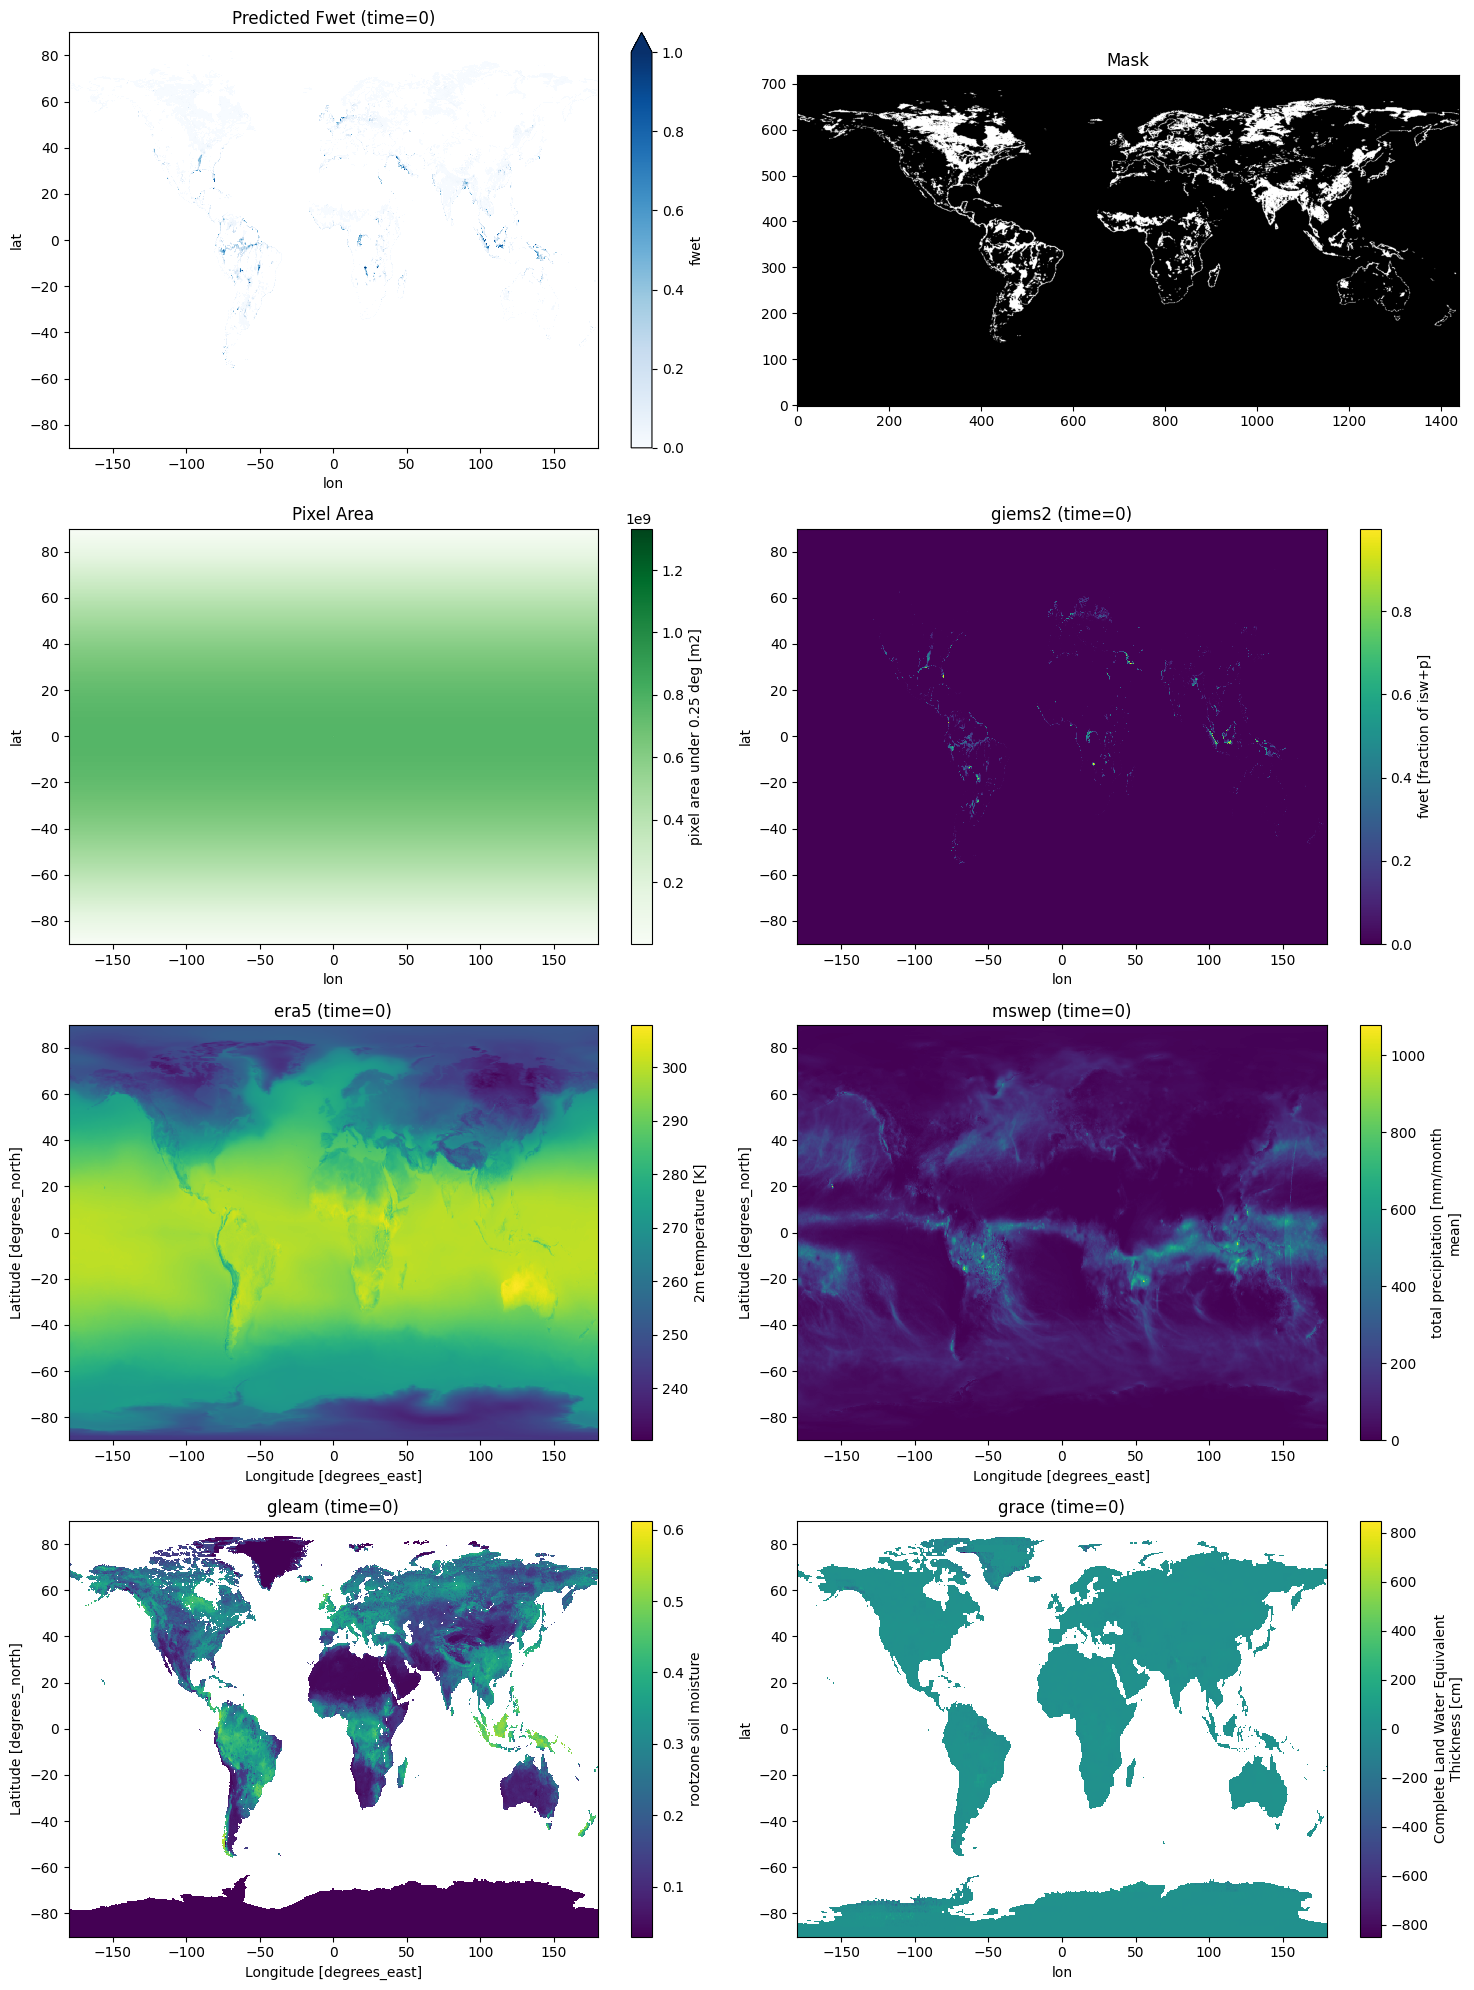

In [7]:
# Overall view
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()
pred["fwet"].isel(time=0).plot(ax=axes[0], cmap="Blues", vmin=0, vmax=1)
axes[0].set_title("Predicted Fwet (time=0)")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
# flip upside down for mask
axes[1].invert_yaxis()
pixel_area["area"].plot(ax=axes[2], cmap="Greens")
axes[2].set_title("Pixel Area")

for i, var in enumerate(TVARs.keys()):
    TVARs[var].isel(time=0).plot(ax=axes[i + 3], cmap="viridis")
    axes[i + 3].set_title(f"{var} (time=0)")
fig.tight_layout()

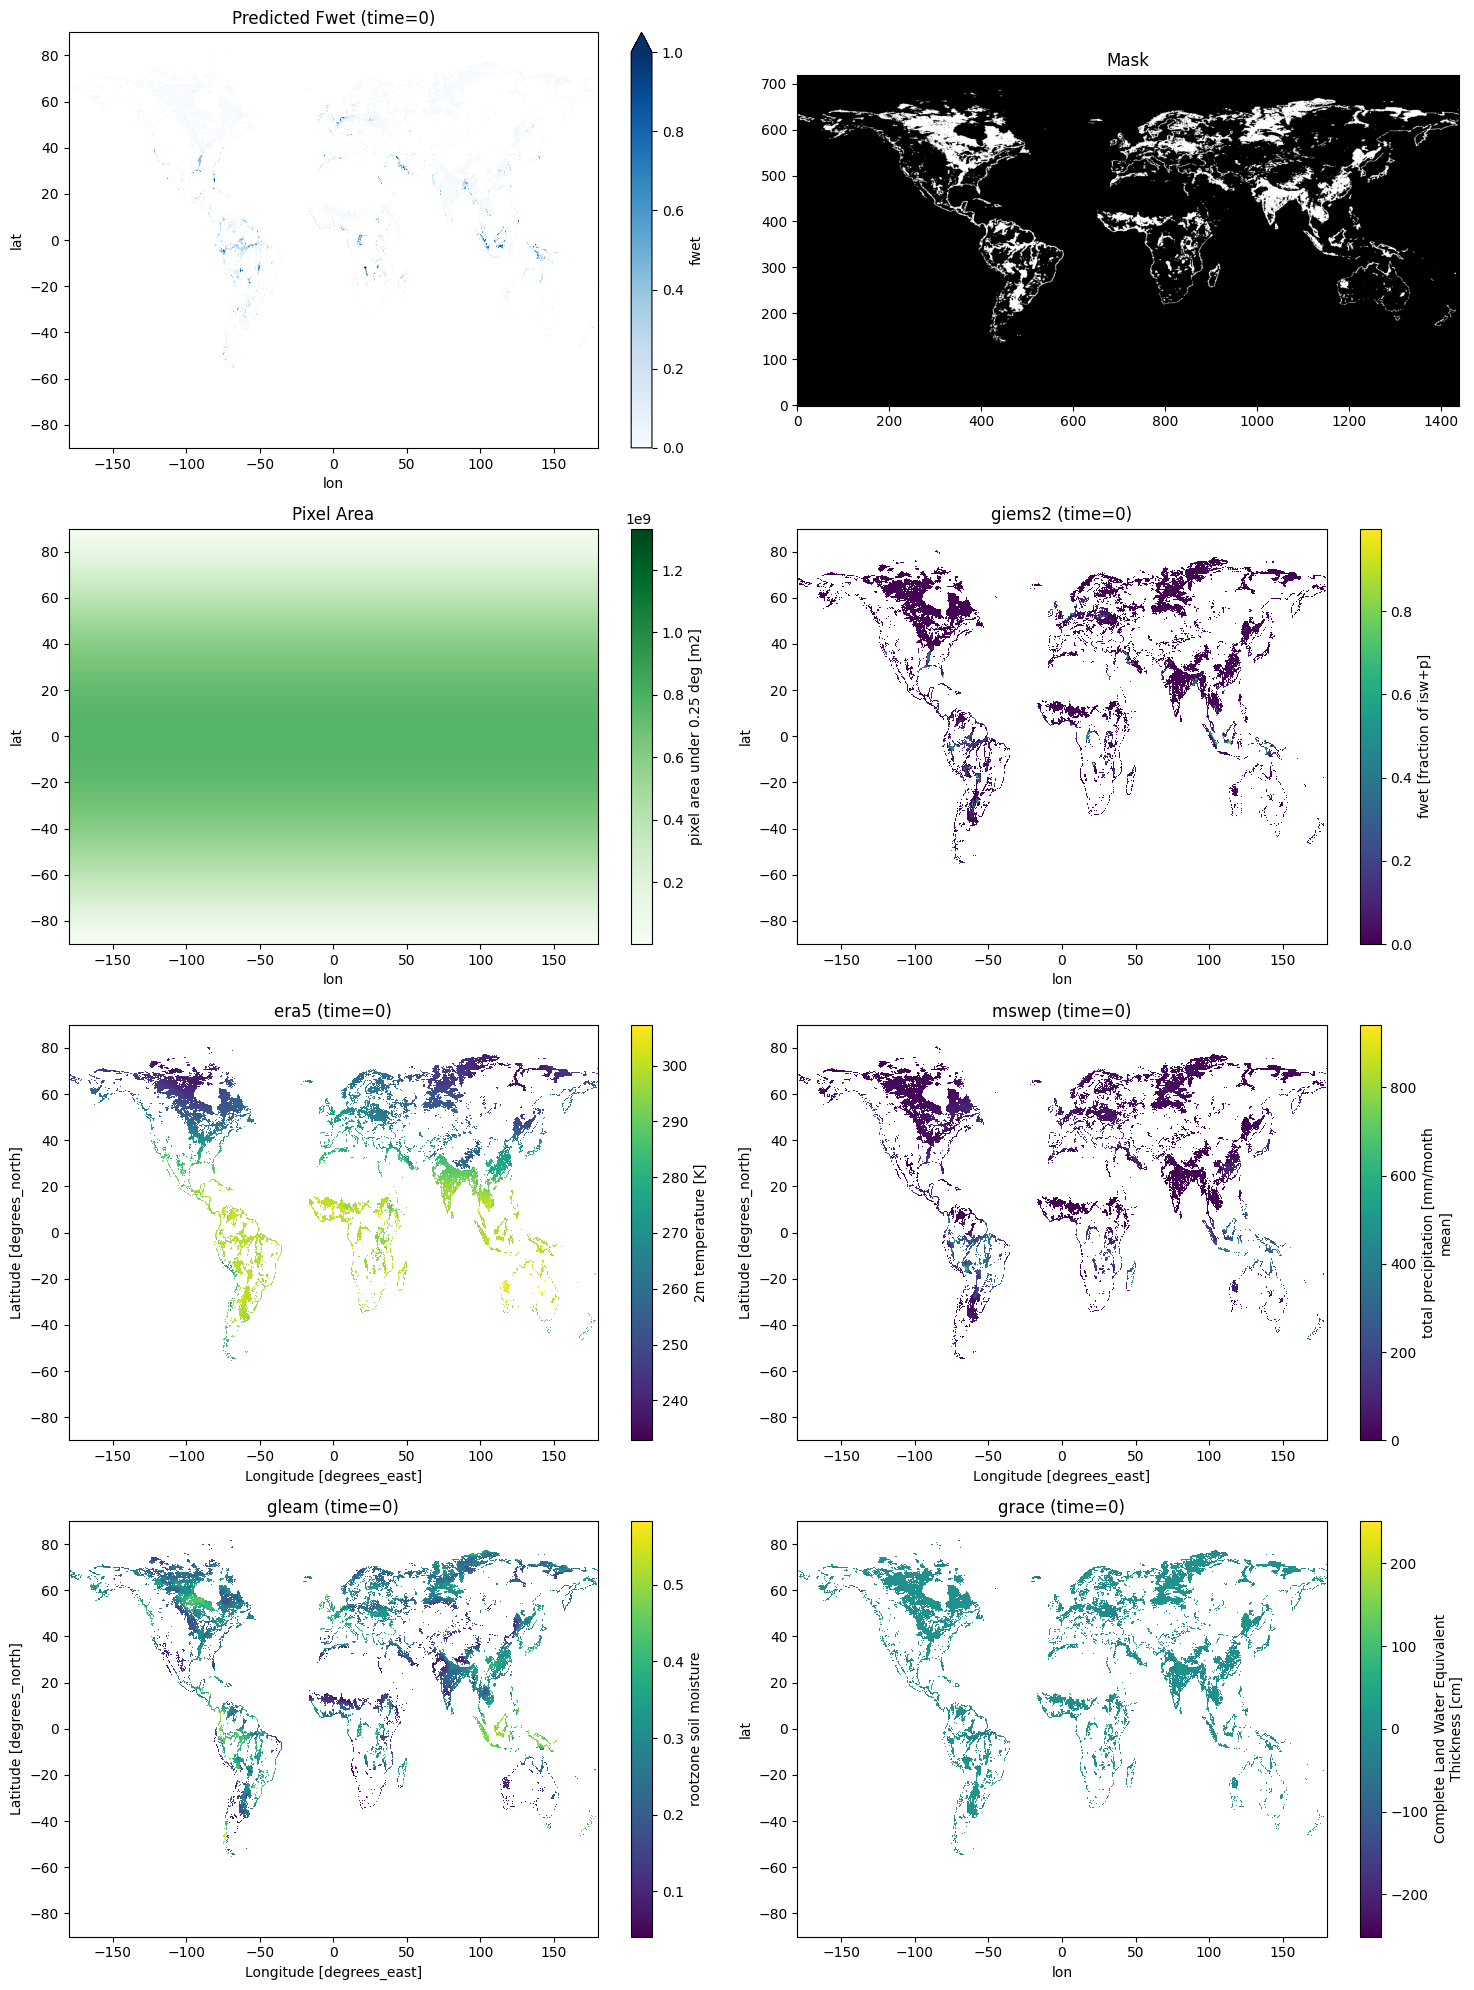

In [8]:
# all the data need to be masked
for var in TVARs.keys():
    TVARs[var] = TVARs[var].where(mask)

pred = pred.transpose("time", "lat", "lon")
pred["fwet"] = pred["fwet"].where(mask)

# check again
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()
pred["fwet"].isel(time=0).plot(ax=axes[0], cmap="Blues", vmin=0, vmax=1)
axes[0].set_title("Predicted Fwet (time=0)")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
# flip upside down for mask
axes[1].invert_yaxis()
pixel_area["area"].plot(ax=axes[2], cmap="Greens")
axes[2].set_title("Pixel Area")

for i, var in enumerate(TVARs.keys()):
    TVARs[var].isel(time=0).plot(ax=axes[i + 3], cmap="viridis")
    axes[i + 3].set_title(f"{var} (time=0)")
fig.tight_layout()

In [9]:
# apply weights
pred_area = pred["fwet"] * pixel_area["area"]
giems_area = TVARs["giems2"] * pixel_area["area"]

weight = np.nanmax(TVARs["giems2"].values, axis=0)
grace_weighted = TVARs["grace"] * weight
mswep_weighted = TVARs["mswep"] * weight
gleam_weighted = TVARs["gleam"] * weight

C:\Users\FireFighter\AppData\Local\Temp\ipykernel_15488\70453930.py:5: RuntimeWarning: All-NaN slice encountered
  weight = np.nanmax(TVARs["giems2"].values, axis=0)


## Global

In [10]:
def compute_GY(dataarray: xr.DataArray):
    return dataarray.mean(dim=["lat", "lon"], skipna=True).resample(time="YS").mean()


pred_area_GY = compute_GY(pred_area)
giems_area_GY = compute_GY(giems_area)
grace_weighted_GY = compute_GY(grace_weighted)
mswep_weighted_GY = compute_GY(mswep_weighted)
gleam_weighted_GY = compute_GY(gleam_weighted)

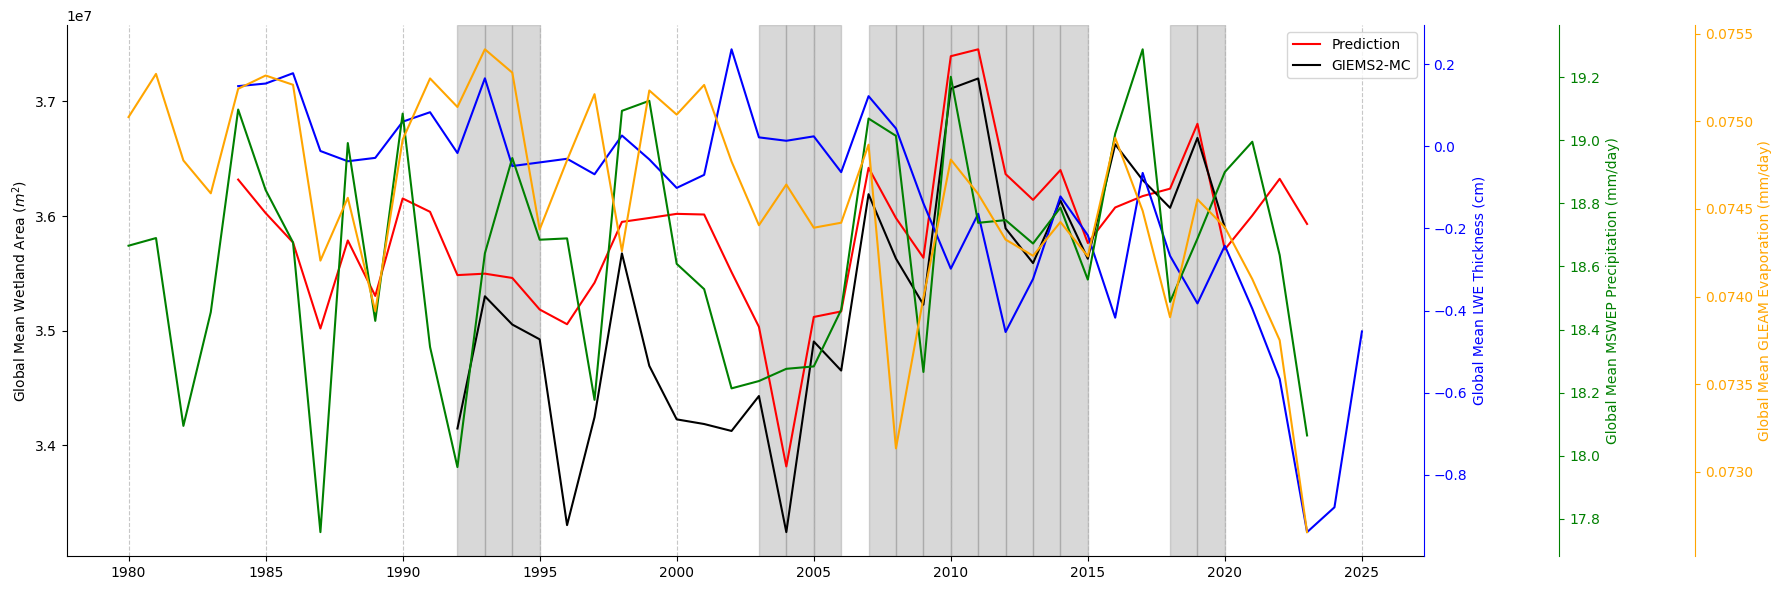

In [11]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(
    pred_area_GY.time,
    pred_area_GY,
    label="Prediction",
    color="red",
)
ax.plot(
    giems_area_GY.time,
    giems_area_GY,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel("Global Mean Wetland Area ($m^2$)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()


def draw_compare(dataarray, offset, label, color):
    bx = ax.twinx()
    bx.plot(
        dataarray.time,
        dataarray,
        color=color,
    )
    bx.spines["right"].set_position(("axes", offset))
    bx.spines["right"].set_color(color)
    bx.spines["left"].set_visible(False)
    bx.spines["top"].set_visible(False)
    bx.spines["bottom"].set_visible(False)
    bx.grid(False)
    bx.set_ylabel(label, color=color)
    bx.yaxis.label.set_color(color)
    bx.tick_params(axis="y", colors=color)


draw_compare(grace_weighted_GY, 1, "Global Mean LWE Thickness (cm)", "blue")
draw_compare(
    mswep_weighted_GY, 1.1, "Global Mean MSWEP Precipitation (mm/day)", "green"
)
draw_compare(gleam_weighted_GY, 1.2, "Global Mean GLEAM Evaporation (mm/day)", "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

fig.tight_layout()

In [12]:
# Let's see global monthly
def compute_GM(dataarray: xr.DataArray):
    return dataarray.mean(dim=["lat", "lon"], skipna=True).resample(time="MS").mean()


pred_area_GM, giems_area_GM, grace_weighted_GM, mswep_weighted_GM, gleam_weighted_GM = (
    map(
        compute_GM,
        [
            pred_area,
            giems_area,
            grace_weighted,
            mswep_weighted,
            gleam_weighted,
        ],
    )
)

In [ ]:
"""Template for plotting
pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()

draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()
"""

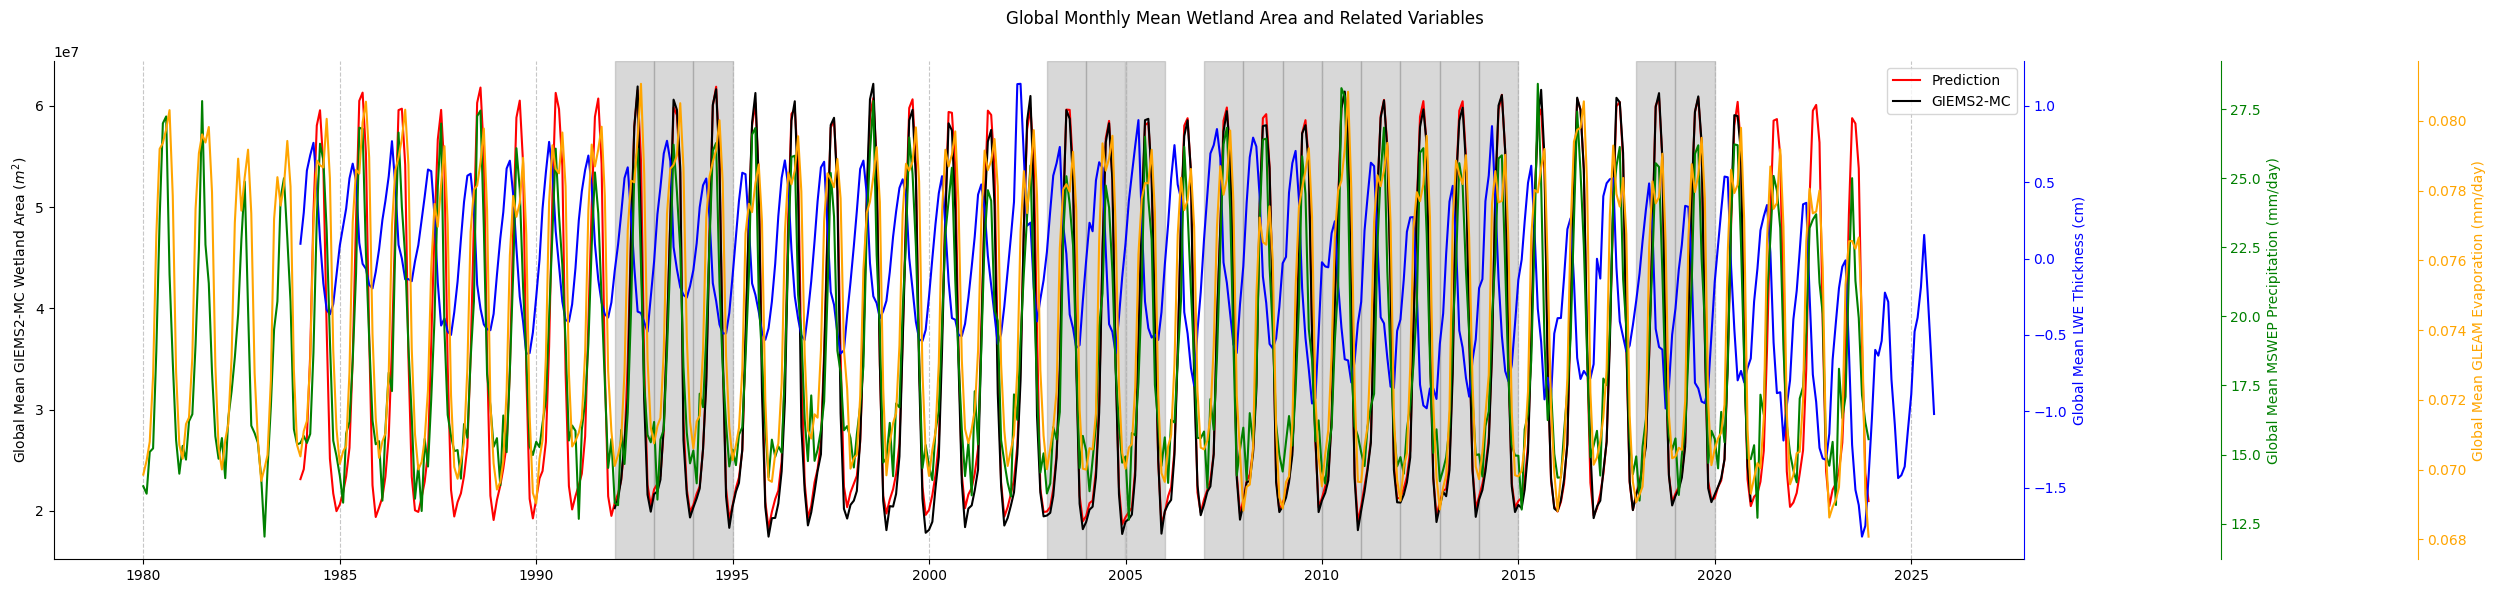

In [13]:
datas = (
    pred_area_GM,
    giems_area_GM,
    grace_weighted_GM,
    mswep_weighted_GM,
    gleam_weighted_GM,
)
title = "Global Monthly Mean Wetland Area and Related Variables"
ylabel = {
    "pred": "Global Mean Predicted Wetland Area ($m^2$)",
    "giems": "Global Mean GIEMS2-MC Wetland Area ($m^2$)",
    "grace": "Global Mean LWE Thickness (cm)",
    "mswep": "Global Mean MSWEP Precipitation (mm/day)",
    "gleam": "Global Mean GLEAM Evaporation (mm/day)",
}


pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()

draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")
# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()

## Tropical

lat : -30 to 30

In [14]:
def compute_TY(dataarray: xr.DataArray):
    return (
        dataarray.sel(lat=slice(-30, 30))
        .mean(dim=["lat", "lon"], skipna=True)
        .resample(time="YS")
        .mean()
    )


datas = (
    compute_TY(pred_area),
    compute_TY(giems_area),
    compute_TY(grace_weighted),
    compute_TY(mswep_weighted),
    compute_TY(gleam_weighted),
)

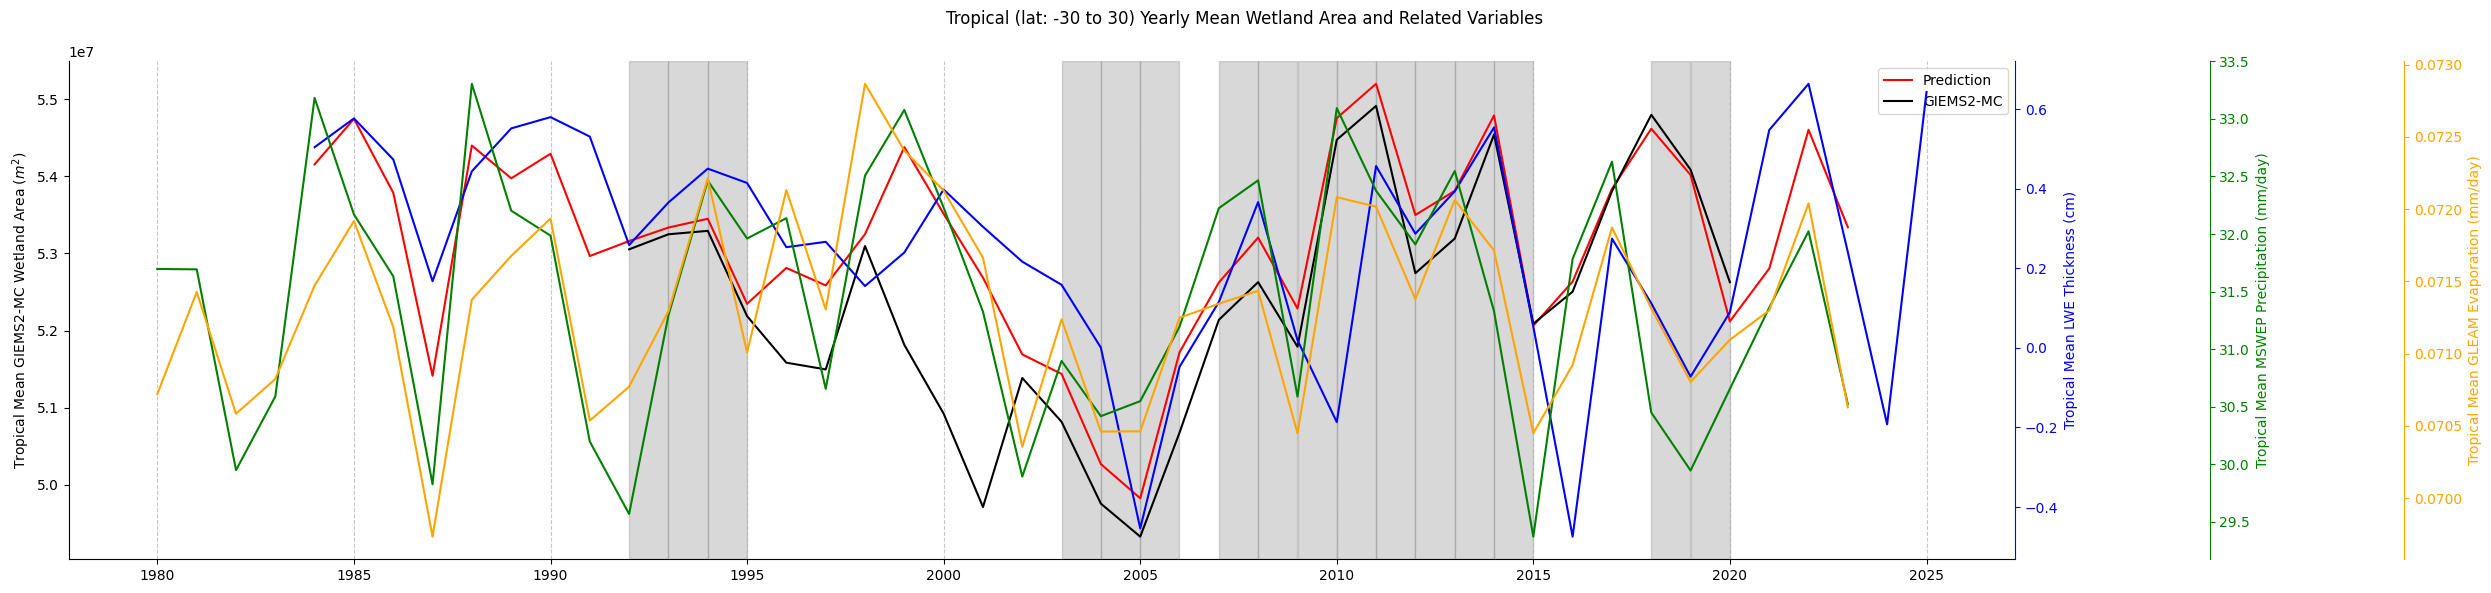

In [ ]:
title = "Tropical (lat: -30 to 30) Yearly Mean Wetland Area and Related Variables"
ylabel = {
    "pred": "Tropical Mean Predicted Wetland Area ($m^2$)",
    "giems": "Tropical Mean GIEMS2-MC Wetland Area ($m^2$)",
    "grace": "Tropical Mean LWE Thickness (cm)",
    "mswep": "Tropical Mean MSWEP Precipitation (mm/day)",
    "gleam": "Tropical Mean GLEAM Evaporation (mm/day)",
}

pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()


draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()

In [16]:
# Tropical Monthly
def compute_TM(dataarray: xr.DataArray):
    return (
        dataarray.sel(lat=slice(-30, 30))
        .mean(dim=["lat", "lon"], skipna=True)
        .resample(time="MS")
        .mean()
    )


datas = (
    compute_TM(pred_area),
    compute_TM(giems_area),
    compute_TM(grace_weighted),
    compute_TM(mswep_weighted),
    compute_TM(gleam_weighted),
)

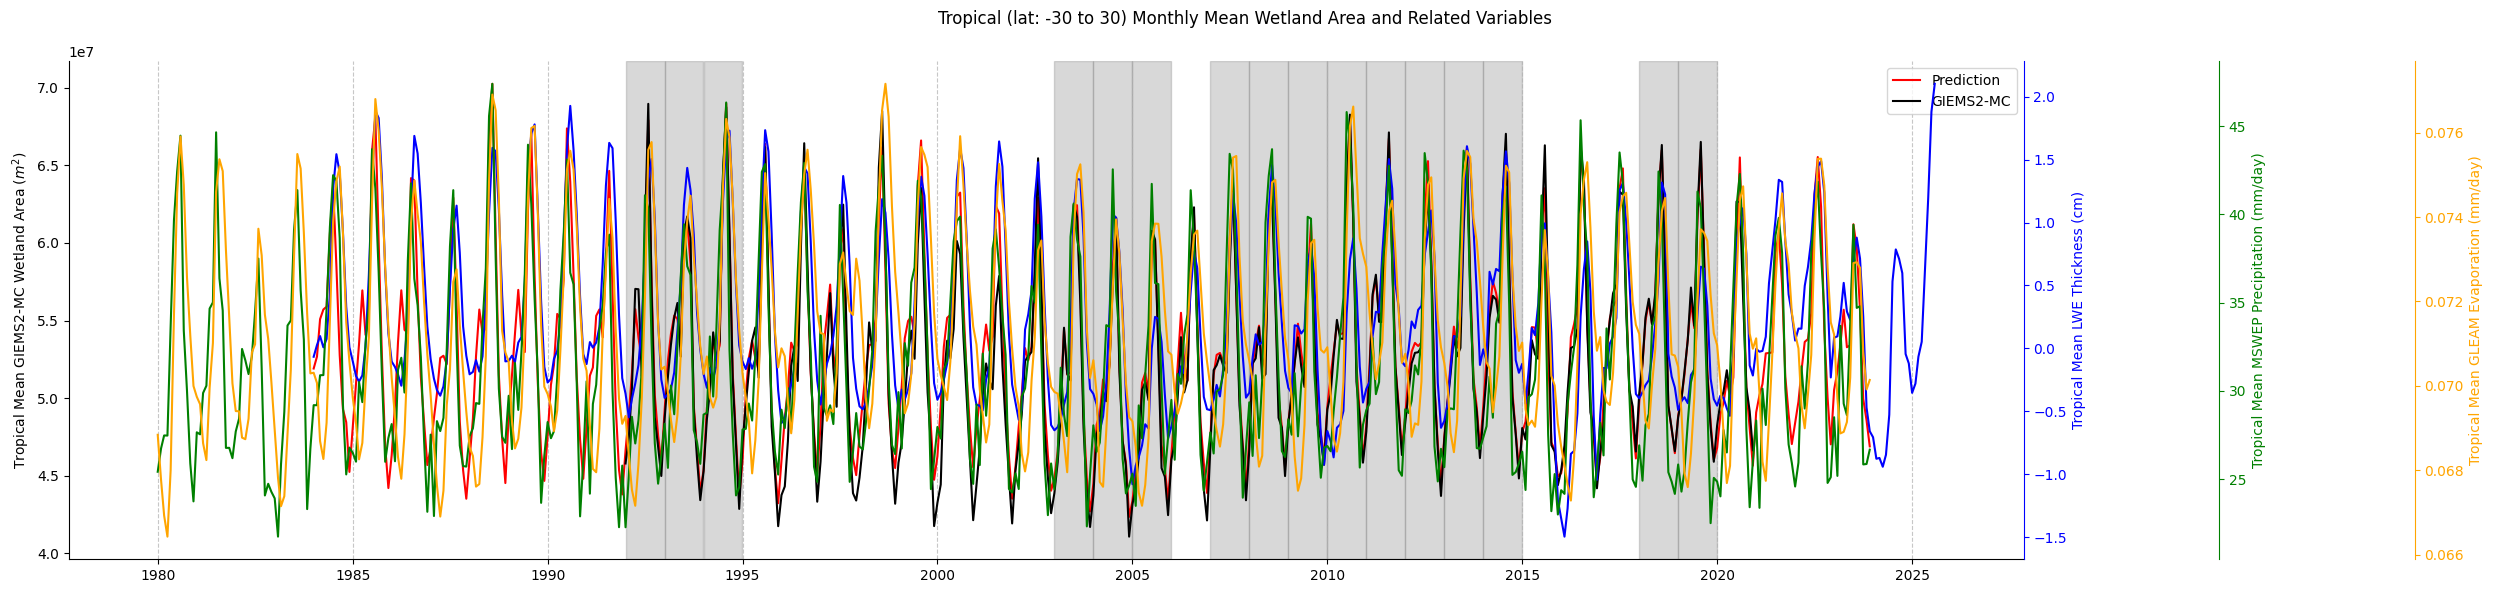

In [17]:
title = "Tropical (lat: -30 to 30) Monthly Mean Wetland Area and Related Variables"
ylabel = {
    "pred": "Tropical Mean Predicted Wetland Area ($m^2$)",
    "giems": "Tropical Mean GIEMS2-MC Wetland Area ($m^2$)",
    "grace": "Tropical Mean LWE Thickness (cm)",
    "mswep": "Tropical Mean MSWEP Precipitation (mm/day)",
    "gleam": "Tropical Mean GLEAM Evaporation (mm/day)",
}

pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()


draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()

## RMSE of Global Mean Time Series

In [19]:
time = giems.time
pred_selected = pred_area.sel(time=time)
pred_selected

<xarray.DataArray (time: 348, lat: 720, lon: 1440)> Size: 3GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-01 1992-02-01 ... 2020-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2

In [21]:
# Calculate RMSE on each grid cell
rmse_grid = np.sqrt(((pred_selected - giems_area) ** 2).mean(dim="time", skipna=True))
rmse_grid

<xarray.DataArray (lat: 720, lon: 1440)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2
    source:        pixels to be trained (no constant peatlands, no snow cover...

Text(0.5, 1.0, 'RMSE of Predicted Wetland Area ($m^2$)')

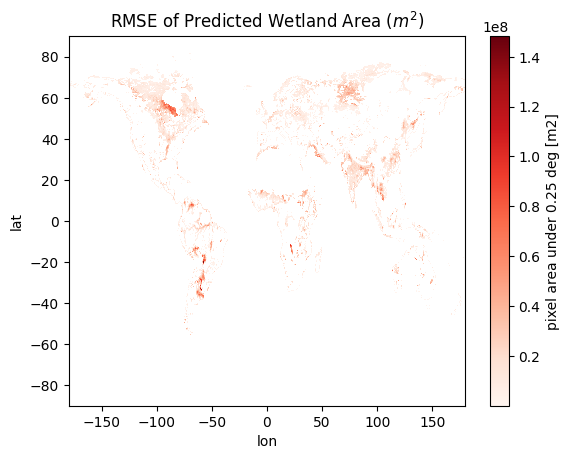

In [23]:
rmse_grid.plot(cmap="Reds")
plt.title("RMSE of Predicted Wetland Area ($m^2$)")

In [24]:
rmse_time = np.sqrt(
    ((pred_selected - giems_area) ** 2).mean(dim=["lat", "lon"], skipna=True)
)
rmse_time

<xarray.DataArray (time: 348)> Size: 3kB
array([19910120.62969402, 21118238.28941476, 21712205.91775753,
       21593387.07158104, 37306302.88294856, 27734418.43644761,
       29458255.36591517, 25635782.80886671, 35656694.28232211,
       35476667.82288517, 21947006.07046538,  7031337.07836555,
        8198311.63790825,  9956872.01898986,  9682117.61670299,
       10810718.69664742, 12943114.89910538, 14458545.03186001,
       11789425.92239183, 13143844.63607155, 13219065.55980103,
       14387642.86485326,  8373884.90819901,  6429895.56497047,
        7784768.44943995,  7953700.88395342,  8014926.23015717,
        9037093.23730357, 12903367.66442164, 12826360.76067537,
       13007423.8080305 , 13384533.75941063, 11554373.67934074,
       11171175.06417756,  7344230.48638501,  5786282.21026972,
       16798343.58770897, 18632623.77845631, 19674817.36453754,
       21845694.90547279, 35653312.7992081 , 21185152.82861984,
       21388927.35884447, 22168534.83205991, 23925271.63630829,
       39065648.07498372, 20267884.12744234, 15833018.82126343,
       17870340.34445665, 21770598.26352105, 19569356.38340368,
       21280388.16653533, 35067807.87861938, 28056954.12428693,
       23722276.99728883, 23281798.32050246, 29510375.1509884 ,
       34228167.45610471, 20722464.53038879, 17429668.22991439,
...
       18120435.3795593 , 19955723.32440005, 19875494.50274085,
       21622758.70299704, 32361646.12595977, 23054305.21442303,
       22494539.08510279, 20796449.04662195, 22074660.86194959,
       34594324.80503853, 31004046.2093154 , 15423785.39503566,
       16308494.28165692, 17610249.69577821, 17804274.87224221,
       21953896.78040734, 33210740.40453009, 26702017.35674206,
       22200041.3842714 , 21233824.20635617, 20889661.54478203,
       34698097.92792943, 18565820.33950698, 13807056.34975553,
        8679998.35649146,  8239855.04679065,  8796400.08541126,
        9213170.80320774, 10608366.79421839, 10101491.44236649,
        9580624.77443267, 10201049.53758603,  9693498.82703009,
        9337332.16216601,  7910422.64200881,  6853049.8579964 ,
        6841316.88172137,  9819324.3795828 ,  7416757.39275333,
        8132832.1073388 , 13639550.79510037,  8679044.11262231,
        8922695.67288334,  9757083.9132936 ,  8712751.18628454,
        9259794.24209628,  6179652.51785498,  7369530.60567867,
       16630270.53107   , 20522225.7143599 , 17669516.45515013,
       19328366.22992837, 39405168.90979125, 24009847.89968686,
       21750135.22238508, 21381783.66848585, 21162557.51866989,
       33598119.81762972, 22648808.39916646, 17266647.64972793])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-01 1992-02-01 ... 2020-12-01
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2
    source:        pixels to be trained (no constant peatlands, no snow cover...

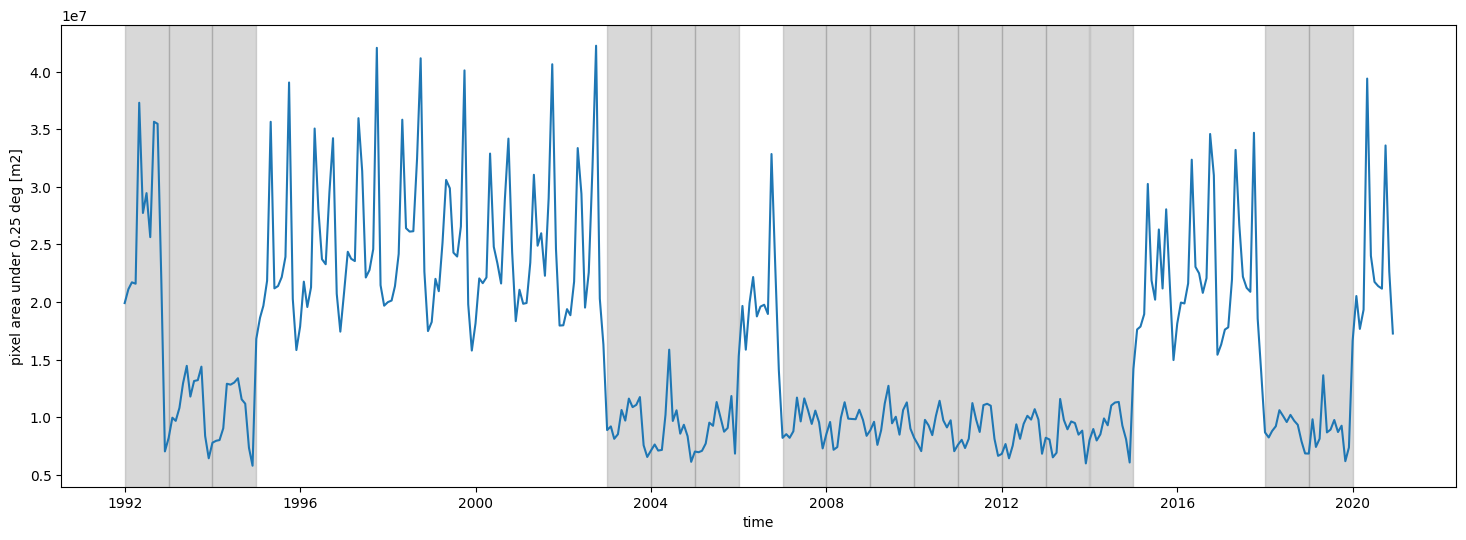

In [26]:
fig, ax = plt.subplots(figsize=(18, 6))
rmse_time.plot(ax=ax)
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

In [28]:
# sMAPE = 2 * |F - A| / (|F| + |A|)
smape = (
    2
    * np.abs(pred_selected - giems_area)
    / (np.abs(pred_selected) + np.abs(giems_area))
)
smape_time = smape.mean(dim=["lat", "lon"], skipna=True)
smape_time

<xarray.DataArray (time: 348)> Size: 3kB
array([1.46145143, 1.47368488, 1.43729616, 1.35978767, 1.22974368,
       0.93648113, 0.64607292, 0.53615838, 0.83747065, 1.24719827,
       1.42160359, 1.41623307, 1.43496068, 1.45082627, 1.42771165,
       1.2819947 , 1.08716766, 0.82278331, 0.48496096, 0.50581646,
       0.65758151, 1.2037319 , 1.35778616, 1.4338233 , 1.42956985,
       1.44472033, 1.42714695, 1.31939355, 1.13355214, 0.82868662,
       0.48076143, 0.45965586, 0.6237829 , 1.04174023, 1.33810976,
       1.42347391, 1.47519997, 1.45736993, 1.44246691, 1.36601841,
       1.16733756, 0.85742857, 0.56809049, 0.53021782, 0.73355394,
       1.14898353, 1.43112639, 1.50320578, 1.49474689, 1.5024112 ,
       1.48404511, 1.4307242 , 1.23185318, 0.90340599, 0.58898401,
       0.53485395, 0.73242763, 1.22019136, 1.39201067, 1.49251572,
       1.49921992, 1.47390607, 1.44029644, 1.38574846, 1.18290173,
       0.90071452, 0.56545694, 0.54381809, 0.69635588, 1.22315305,
       1.4186539 , 1.46643237, 1.4643706 , 1.45567627, 1.45748779,
       1.35734662, 1.16752951, 0.85171725, 0.55842227, 0.52180233,
       0.73599692, 1.18211756, 1.44606657, 1.50139813, 1.47996386,
       1.49948532, 1.47542328, 1.3831179 , 1.17445539, 0.91388236,
       0.56583779, 0.53139522, 0.71184381, 1.18275811, 1.4271513 ,
       1.49075069, 1.51733889, 1.50232479, 1.4475194 , 1.36307784,
...
       1.29072734, 1.45098427, 1.45108315, 1.43606748, 1.43625415,
       1.37298085, 1.09447785, 0.69885913, 0.47588173, 0.44377657,
       0.53332085, 0.9309014 , 1.26804215, 1.42017667, 1.42361245,
       1.41731964, 1.36181012, 1.26877902, 1.077979  , 0.71309379,
       0.47524558, 0.43806788, 0.53719249, 1.02169213, 1.29466975,
       1.38723708, 1.44588139, 1.44999246, 1.40956158, 1.32653472,
       1.13067843, 0.829333  , 0.53258439, 0.49855475, 0.595137  ,
       1.1134525 , 1.34195318, 1.41573704, 1.47094376, 1.44720136,
       1.40886308, 1.32220671, 1.08747244, 0.80188826, 0.50577426,
       0.489807  , 0.61655602, 1.10713687, 1.38308195, 1.4594188 ,
       1.46992989, 1.45683672, 1.40336697, 1.33287201, 1.15128223,
       0.85413306, 0.52541361, 0.48590468, 0.58350474, 1.10708278,
       1.34894228, 1.43260676, 1.3992937 , 1.41102445, 1.40023336,
       1.3276091 , 1.08257783, 0.84714067, 0.46709041, 0.43859507,
       0.54477218, 0.9737875 , 1.27902471, 1.39896681, 1.41156092,
       1.40180134, 1.35831112, 1.26605687, 1.04076706, 0.72668238,
       0.45183873, 0.42809174, 0.50537731, 0.94768652, 1.29847552,
       1.35270848, 1.40979827, 1.41766852, 1.38547856, 1.32385674,
       1.16897221, 0.84860134, 0.52724258, 0.49541084, 0.569466  ,
       1.11741508, 1.33156978, 1.40602017])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-01 1992-02-01 ... 2020-12-01
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2
    source:        pixels to be trained (no constant peatlands, no snow cover...

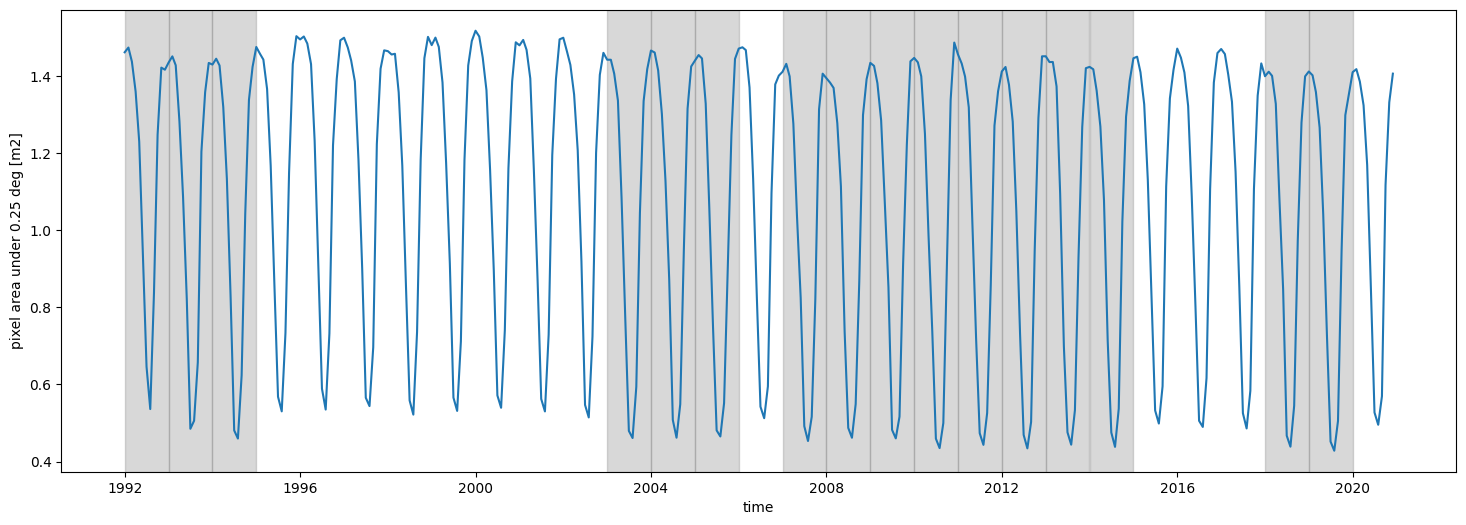

In [29]:
fig, ax = plt.subplots(figsize=(18, 6))
smape_time.plot(ax=ax)
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

In [32]:
# Accuracy = 1 - |F - A| / A
accuracy = 1 - np.divide(
    np.abs(pred_selected - giems_area),
    giems_area,
    out=np.zeros_like(pred_selected),
    where=giems_area != 0,
)
accuracy_time = accuracy.mean(dim=["lat", "lon"], skipna=True)
accuracy_grid = accuracy.mean(dim="time", skipna=True)

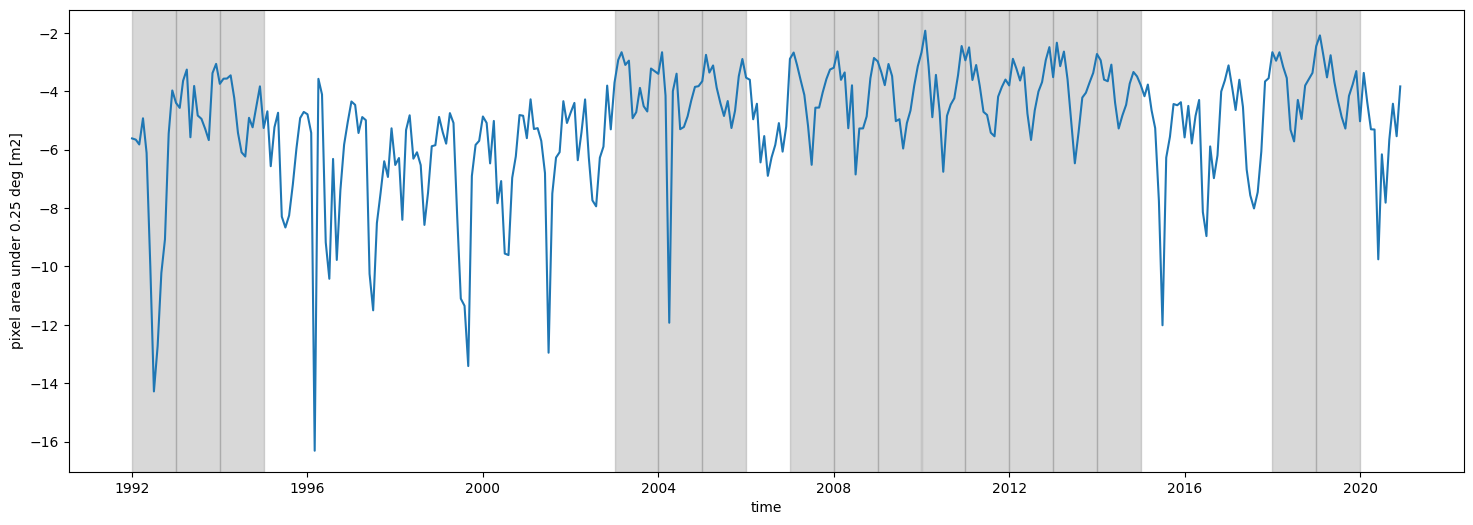

In [33]:
fig, ax = plt.subplots(figsize=(18, 6))
accuracy_time.plot(ax=ax)
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

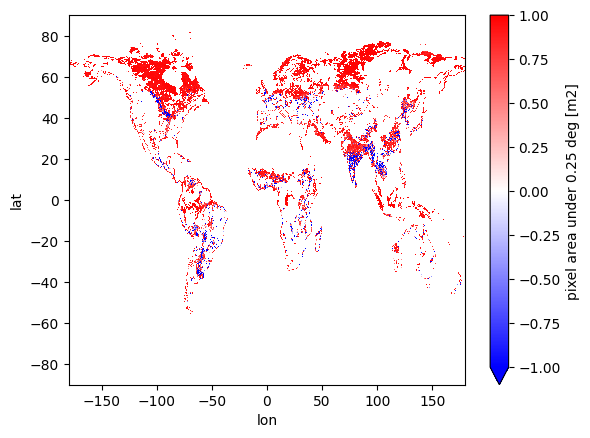

In [36]:
accuracy_grid.plot(vmax=1, vmin=-1, cmap="bwr")